In [20]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import skimage.io as io


# confidence Threshold 설정
CONF_THR = 0.4
CONF_MEAN = 0.7
# 사용할 fold num 설정
fold_num = 1
train_json_path = f'../dataset/train_fold{fold_num}.json'

# test.json inference한 결과 경로 설정
# submission_path = '../work_dirs/cascadeRCNN_swin_l_fpp_rpn_cosineRe_ms/submission_best_bbox_mAP_50_epoch_11.csv'
submission_path = '../dataset/best_7152.csv'

# 결과물이 저장될 root와 이름 설정
output_root = '../dataset'
output_json_name = 'pseudo_train'
output_path = os.path.join(output_root,output_json_name+ f'_f{fold_num}_{int(CONF_THR * 10)}_mean{int(CONF_MEAN * 10)}.json')

# ---------------------------------------------------------------------------------------------------------------- #

with open(train_json_path) as f:
    train_json = json.load(f)

df = pd.read_csv(submission_path)
submission_list = df.values.tolist()

images = []
annotations = []

start_id = train_json['images'][-1]['id']
start_anno_id = train_json['annotations'][-1]['id']

print('pseudo labeling start...')

for bboxes, image_name in submission_list:
    # image
    start_id += 1
    bboxes_splited = bboxes.split()
    num_bbox = 0

# 10개 box 이상 이미지 제거
    conf_box = 0
    conf_total = 0
    for i in range(1, len(bboxes_splited)+1, 6):
        if float(bboxes_splited[i]) >= CONF_THR:
            conf_box += 1
            conf_total += float(bboxes_splited[i])  
    conf_mean = conf_total / (conf_box + 1e-6)
    # if conf_box >= 10:
    #     continue
    if conf_mean < CONF_MEAN:
        # print(image_name, conf_mean)
        continue



    for i in range(6, len(bboxes_splited)+1, 6):
        bbox = bboxes_splited[i-6:i]
        _class, conf, left, top, right, bottom = int(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), float(bbox[5])
        width, height = right - left, bottom - top
        area = round(width * height, 2)

        if conf < CONF_THR:
            continue
        start_anno_id += 1
        num_bbox += 1
        
        annotation = dict()
        annotation['image_id'] = start_id
        annotation['category_id'] = _class
        annotation['area'] = area
        annotation['bbox'] = [round(left, 1), round(top, 1), round(width, 1), round(height, 1)]
        annotation['iscrowd'] = 0
        annotation['id'] = start_anno_id
        annotations.append(annotation)

    if num_bbox != 0:
        image = dict()
        image['width'] = 1024
        image['height'] = 1024
        image['file_name'] = image_name
        image['license'] = 0
        image['flickr_url'] = None
        image['coco_ur'] = None
        image['date_captured'] = "2020-12-12 15:19:33"
        image['id'] = start_id
        images.append(image)

print('pseudo labeling finished...\n')
print(f'{len(images)}개의 images가 추가되었습니다.')
print(f'{len(annotations)}개의 annotations이 추가되었습니다.\n')

train_json['images'] += images
train_json['annotations'] += annotations

print(f'{output_path} 에 저장되었습니다.')

with open(output_path, 'w') as f:
    json.dump(train_json, f)


pseudo labeling start...
test/0001.jpg 0.6733497634986874
test/0002.jpg 0.6971640721226319
test/0004.jpg 0.6928851418291423
test/0006.jpg 0.6464105760557467
test/0007.jpg 0.5207580999844161
test/0010.jpg 0.6281181102711649
test/0011.jpg 0.6453582454357809
test/0012.jpg 0.5588746554744002
test/0017.jpg 0.0
test/0018.jpg 0.6387334321001916
test/0019.jpg 0.6683054107733335
test/0021.jpg 0.574116807219932
test/0034.jpg 0.0
test/0036.jpg 0.6837749784819184
test/0038.jpg 0.6055971509183316
test/0043.jpg 0.5740157922987063
test/0044.jpg 0.5298970407130057
test/0047.jpg 0.6269840288730574
test/0050.jpg 0.580240086626216
test/0052.jpg 0.599128362434748
test/0053.jpg 0.5939603458344632
test/0057.jpg 0.658666975042252
test/0059.jpg 0.6908265196521153
test/0060.jpg 0.6750290270878703
test/0063.jpg 0.6222832260338822
test/0067.jpg 0.5047492701835912
test/0069.jpg 0.6867981922244784
test/0080.jpg 0.6839945096444542
test/0083.jpg 0.6831053006528779
test/0085.jpg 0.6621027505070335
test/0088.jpg 0.565

test/3018.jpg
{'image_id': 7901, 'category_id': 4, 'area': 62792.94, 'bbox': [366.1, 493.5, 348.8, 180.0], 'iscrowd': 0, 'id': 25159}


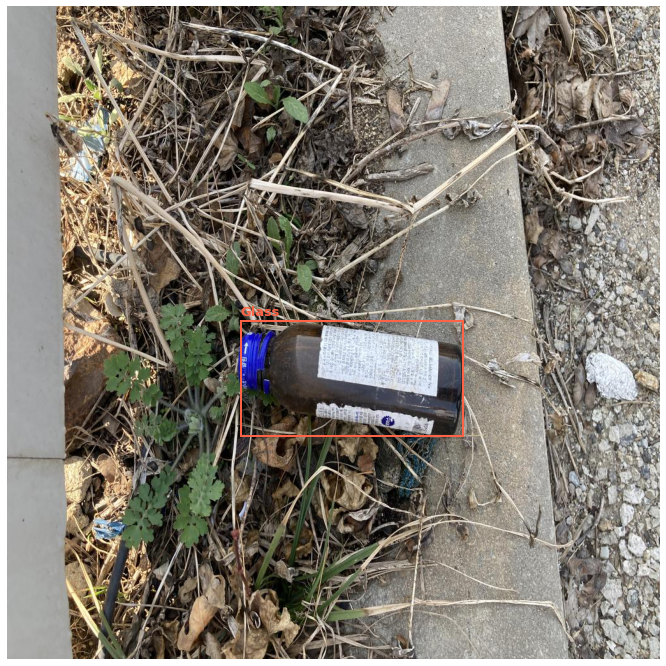

In [11]:
index = random.randrange(len(images))

classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
file_name, id = images[index]['file_name'], images[index]['id']
print(file_name)
I = io.imread(os.path.join('../dataset', file_name))
plt.rcParams["figure.figsize"] = (12,12)
plt.axis('off')
plt.imshow(I)
ax = plt.gca()
for annotation in annotations:
    if id == annotation['image_id']:
        print(annotation)
        box = annotation['bbox']
        bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth = 2, edgecolor = 'tomato',facecolor = 'none')
        ax.add_patch(bb)
        ax.text(box[0], box[1] - 10 , classes[int(annotation['category_id'])], weight = 'bold', color = 'tomato', fontsize = 13)
plt.show()